<a href="https://colab.research.google.com/github/riuls/an2dl_challenge_1/blob/luis/train_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation and analysis


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Deep Learning Challenge

Mounted at /gdrive
/gdrive/MyDrive/Deep Learning Challenge


In [ ]:
from google.colab import files

#!rm -rf models.py
#!rm -rf visualization.py
#!rm -rf data_preparation.py
#files.upload()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import random
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight


seed = 42

random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

X, y = load_data()

X, y, num_outliers = delete_outliers(X, y)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(4503, 96, 96, 3)
(501, 96, 96, 3)
(501, 96, 96, 3)
(4503,)
(array([0, 1]), array([2791, 1712]))
(array([0, 1]), array([310, 191]))


In [ ]:
def display_random_images(X, num_img=10, random_images=True):
  fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
  for i in range(num_img):
      if (random_images):
        image = random.randint(0, X.shape[0] - 1)
      else:
        image = i

      ax = axes[i%2, i%num_img//2]
      ax.imshow(np.clip(X[image], 0, 255))  # Display clipped item images
      ax.text(0.5, -0.1, str(image) + ' ' + str(y[image]), size=12, ha="center", transform=ax.transAxes)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

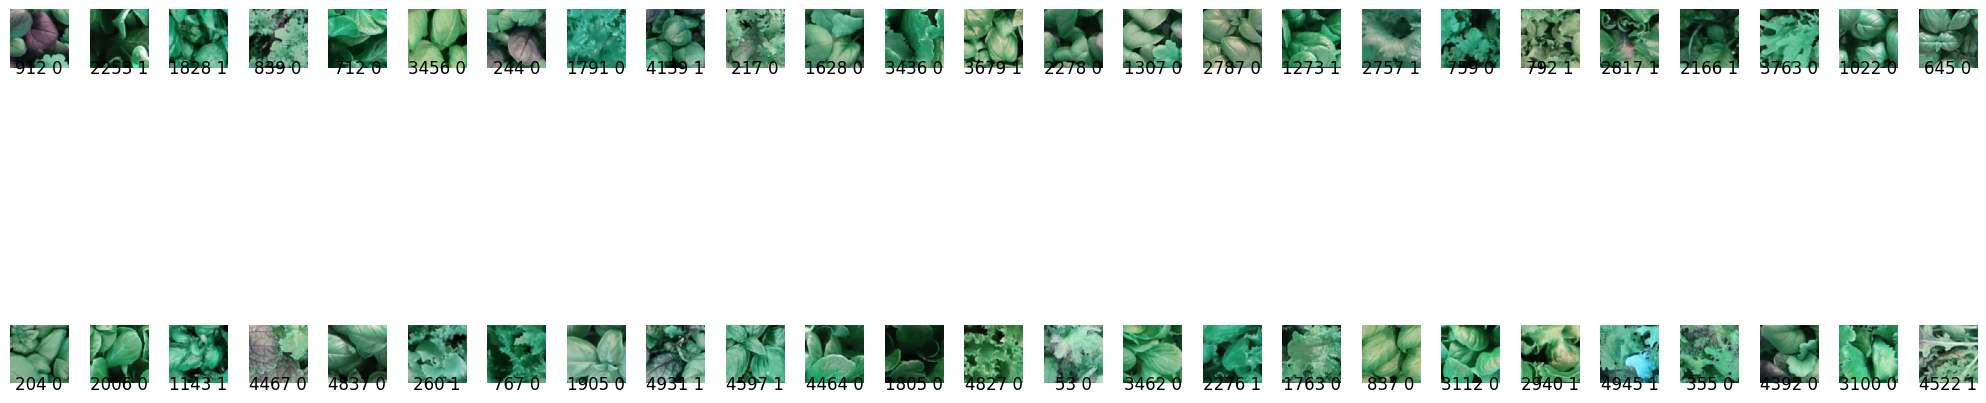

In [ ]:
display_random_images(X, num_img=50)

#Model building

In [ ]:
#from tensorflow.keras.applications.mobilenet import preprocess_input
#from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def get_block_eff_1(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def get_block_eff_2(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dropout(rate = 1/5)(x)
    x = tfkl.Dense(64)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(rate = 1/7)(x)
    x = tfkl.Dense(16)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(rate = 1/7)(x)
    return x

def get_block_xception(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dropout(rate = 1/5)(x)
    x = tfkl.Dense(64)(x)
    #x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(rate = 1/7)(x)
    x = tfkl.Dense(16)(x)
    #x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(rate = 1/7)(x)
    return x




def build_efficient(input_shape, augmentation=tf.keras.Sequential([]), name="EfficientNetV2B3", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=1e-6, neurons=[]):

    efficient = tfk.applications.EfficientNetV2B3(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg'
    )

    efficient.trainable = False

    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    x = efficient(inputs)

    for n in neurons:
      x = get_block_eff_1(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(model.summary())

    # Set a smaller learning rate to correct oscillations
    learning_rate = 1e-5

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

def build_mobile(input_shape, augmentation=tf.keras.Sequential([]), name="MobileNetV2", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=1e-6, neurons=[]):

    mobile = tfk.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )

    mobile.trainable = False

    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    x = mobile(inputs)

    for n in neurons:
      x = get_block_eff_1(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(model.summary())

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

def build_xception(input_shape, augmentation=tf.keras.Sequential([]), name="TransferModel", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=1e-6, neurons=[]):

    xception = tfk.applications.Xception(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )
    xception.trainable = False

    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    x = xception(inputs)

    for n in neurons:
      x = get_block_xception(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(model.summary())

    # Set a smaller learning rate to correct oscillations
    learning_rate = 1e-5

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

def build_whatever(input_shape, augmentation=tf.keras.Sequential([]), name="TransferModel", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=1e-6, neurons=[]):
    #mobile = tfk.applications.MobileNetV2(
    #    input_shape=input_shape,
    #    include_top=False,
    #    weights="imagenet",
    #    pooling='avg',
    #)
    base_model = tfk.applications.EfficientNetV2B3(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg'
    )

    base_model.trainable = False

    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    x = base_model(inputs)

    for n in neurons:
      x = get_block_eff_1(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(model.summary())

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

#Transfer learning and performance analysis

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobile
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
from keras.preprocessing.image import ImageDataGenerator

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5, seed=seed),
      tfkl.RandomFlip("horizontal_and_vertical", seed=seed),
      tfkl.RandomBrightness((-0.3, 0.1), value_range=(0,1), seed=seed),
  ]),
  tf.keras.Sequential([
    tfkl.RandomFlip(),
    tfkl.RandomZoom(0.4, fill_mode = 'reflect'),
    tfkl.RandomBrightness(0.1, value_range=(0,255)),
    tfkl.RandomRotation((-1,1), fill_mode = 'reflect'),
  ])
]

models = [
    build_efficient(X_train.shape[1:], neurons=[128, 64], dropout=0.5, batch_normalization=True, learning_rate=8e-5, weight_decay=5e-5, name="EfficientNet", augmentation=augmentations[0]),
    build_mobile(X_train.shape[1:], neurons=[64, 16], dropout=0.2, batch_normalization=True, learning_rate=8e-5, weight_decay=2e-5, name="MobileNetV2", augmentation=augmentations[0]),
    build_xception(X_train.shape[1:], neurons=[64, 16], dropout=0.2, batch_normalization=False, learning_rate=8e-5, weight_decay=2e-5, name="Xception", augmentation=augmentations[0])
    ]

batch_size = 64

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = {
    0: weights[0],
    1: weights[1]
}

patience = 20

histories = []

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)


for i, batch in enumerate(models):

  if i == 0:
    x_train = preprocess_efficient(X_train * 255)
    x_val = preprocess_efficient(X_val * 255)
  elif i == 1:
    x_train = preprocess_mobile(X_train * 255)
    x_val = preprocess_mobile(X_val * 255)
  elif i == 2:
    x_train = preprocess_xception(X_train * 255)
    x_val = preprocess_xception(X_val * 255)
  else:
    x_train = preprocess_mobile(X_train * 255)
    x_val = preprocess_mobile(X_val * 255)

  histories.append(
      models[i].fit(
        datagen.flow(x_train, y_train, batch_size=32,subset='training'),
        batch_size = batch_size,
        epochs = 400,
        class_weight = class_weights,
        validation_data=datagen.flow(x_val, y_val, batch_size=8, subset='validation'),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.8, patience=20, min_lr=5e-6, mode='max')]
      ).history
  )

52606240/52606240 [==============================] - 0s 0us/step
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                       

16/16 [==============================] - 4s 53ms/step
0.7031413612565445
49


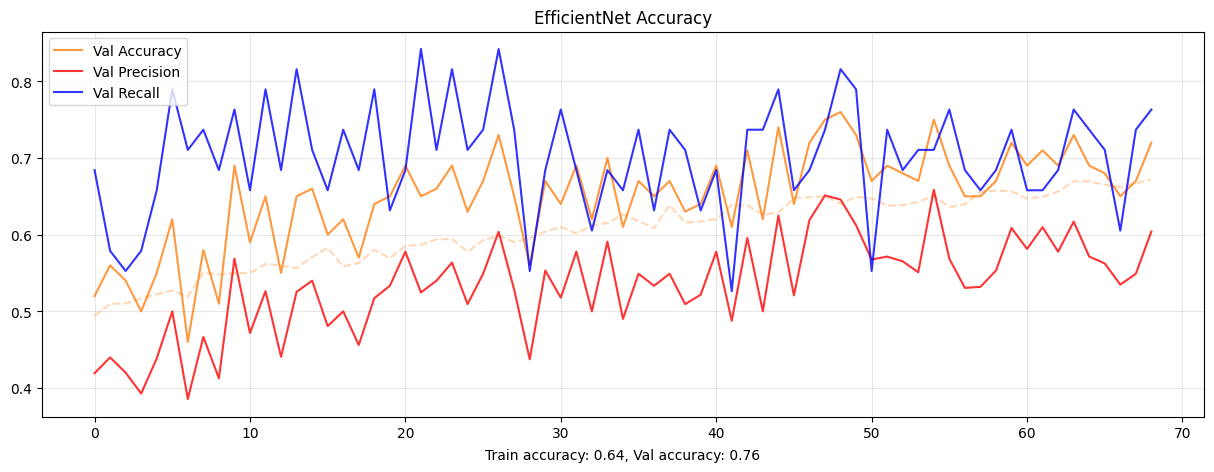

16/16 [==============================] - 2s 65ms/step
0.7802144907954737
31


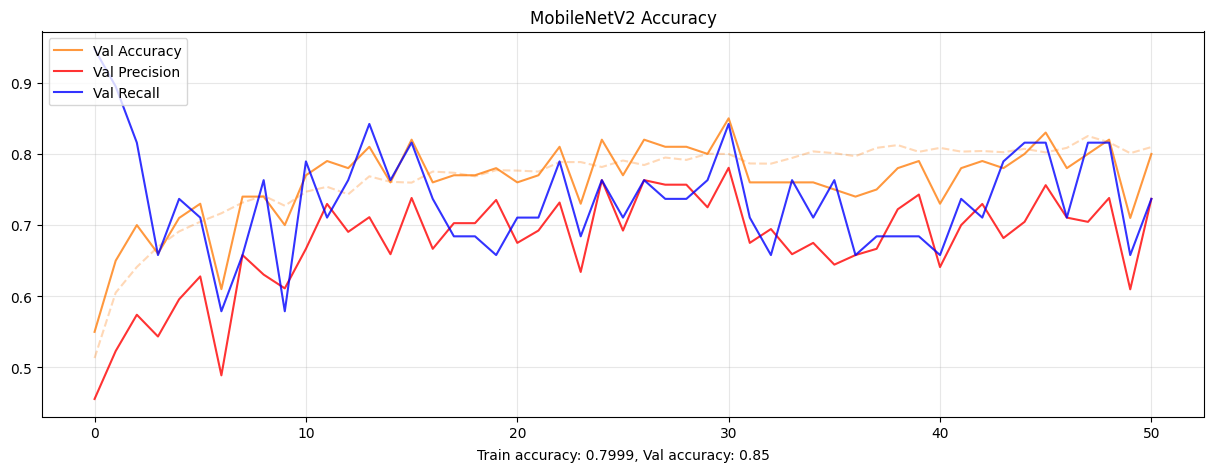

16/16 [==============================] - 3s 100ms/step
0.72175308224962
40


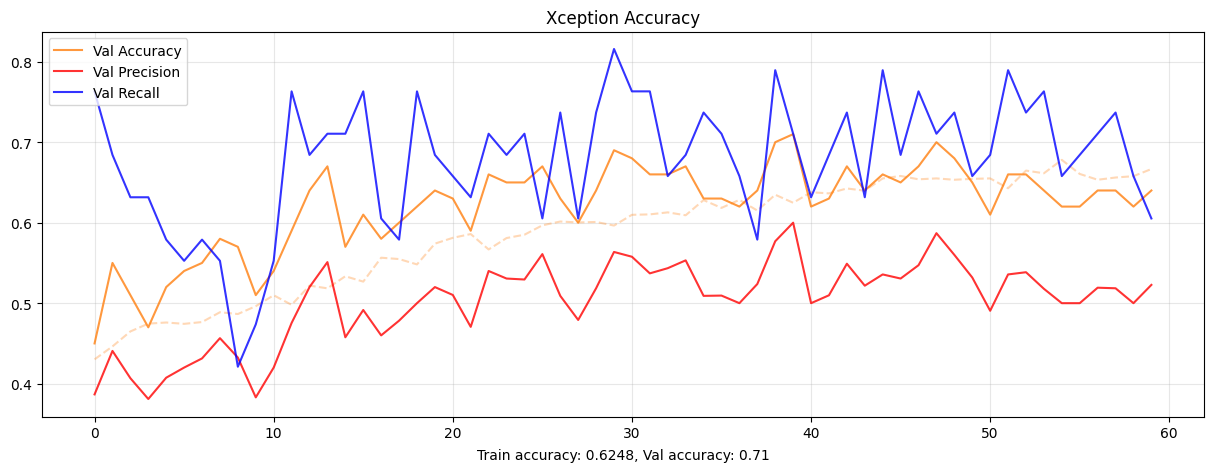

In [ ]:
for i, history in enumerate(histories):
  if i == 0:
    x_val = preprocess_efficient(X_val * 255)
  elif i == 1:
    x_val = preprocess_mobile(X_val * 255)
  elif i == 2:
    x_val = preprocess_xception(X_val * 255)
  else:
    x_val = preprocess_mobile(X_val * 255)

  predictions = models[i].predict(x_val)
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  #print(classification_report(y_val, predictions))
  print(roc_auc)
  print(len(history['val_accuracy']) - patience)
  plot_history(history, models[i].name)

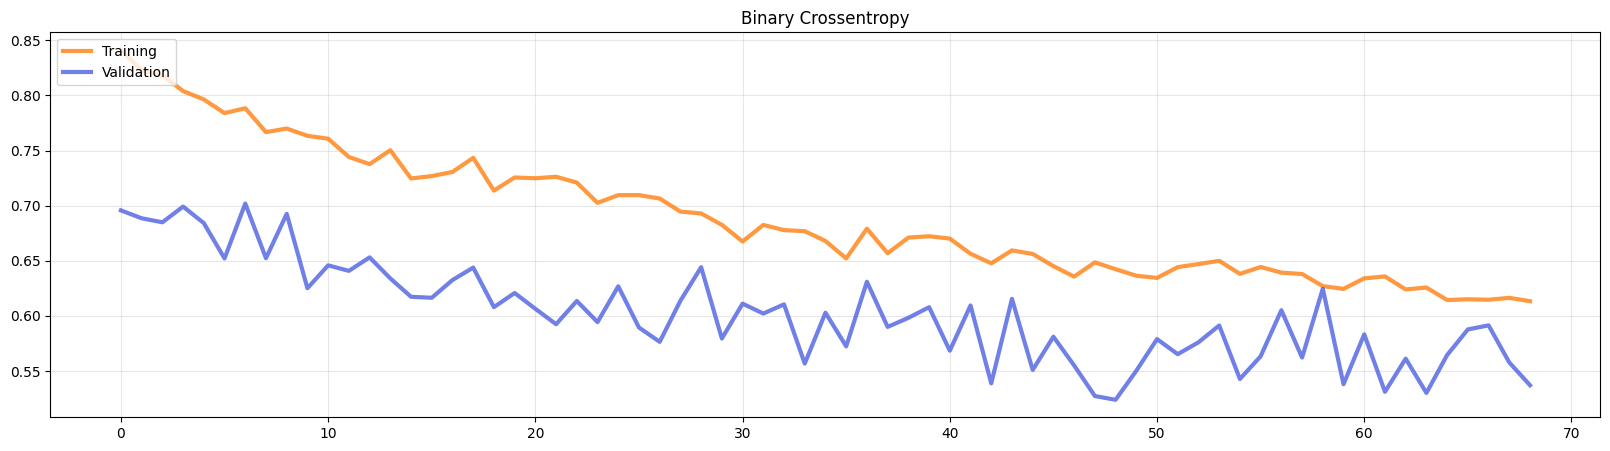

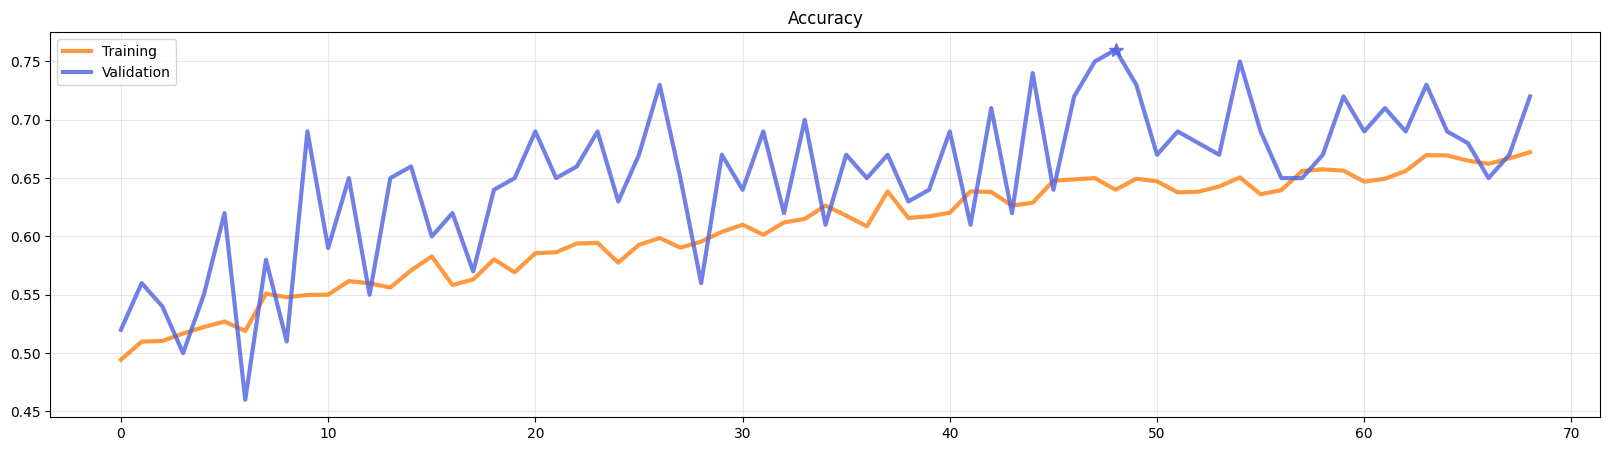

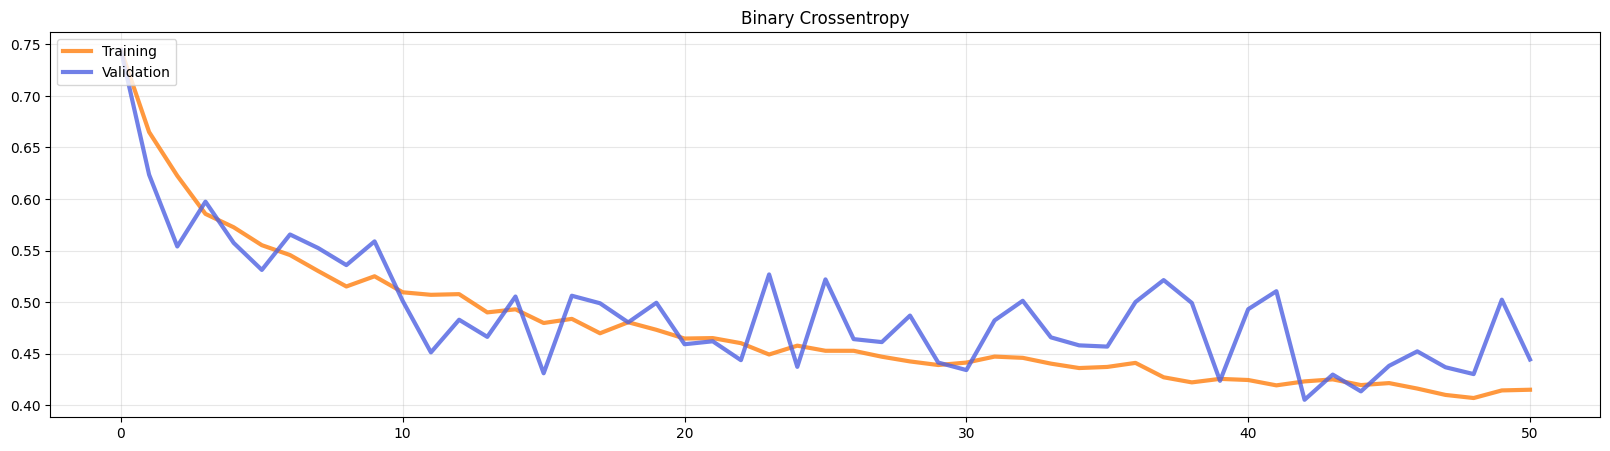

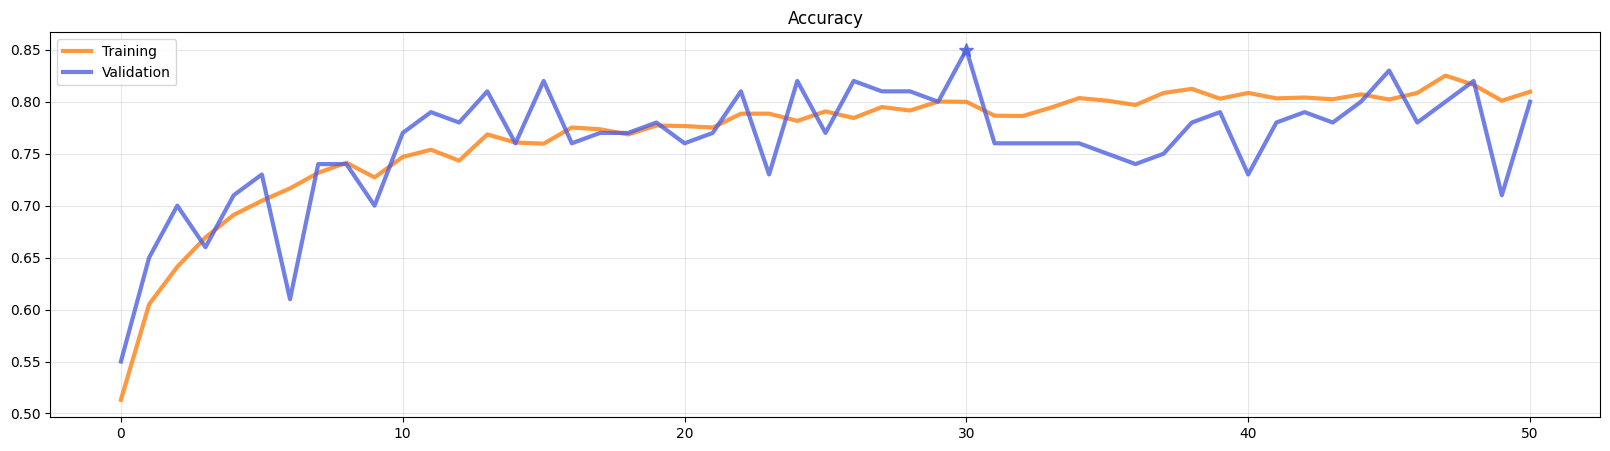

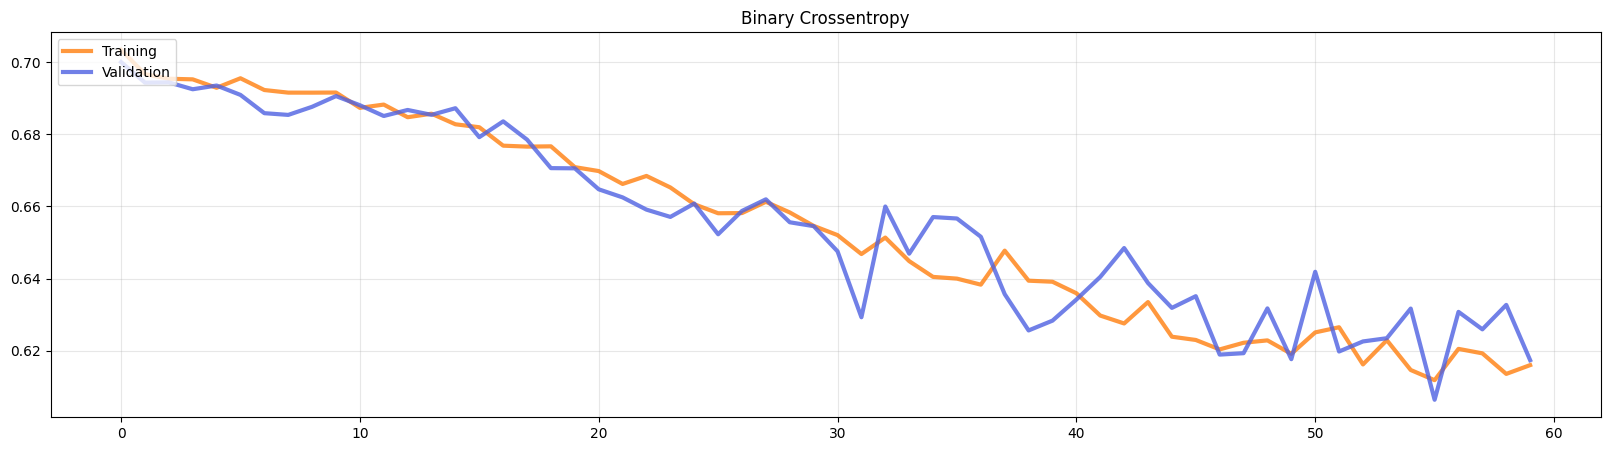

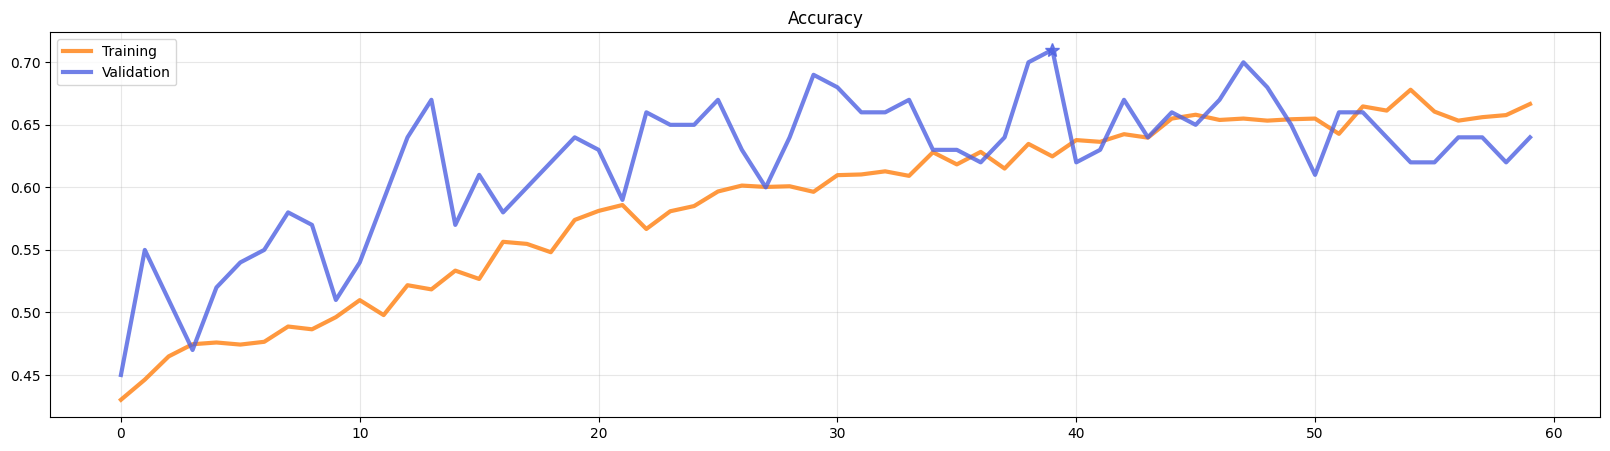

In [ ]:
for i, history in enumerate(histories):
  # Find the epoch with the highest validation accuracy
  best_epoch = np.argmax(history['val_accuracy'])

  # Plot training and validation performance metrics
  plt.figure(figsize=(20, 5))

  # Plot training and validation loss
  plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.legend(loc='upper left')
  plt.title('Binary Crossentropy')
  plt.grid(alpha=0.3)

  plt.figure(figsize=(20, 5))

  # Plot training and validation accuracy, highlighting the best epoch
  plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=0.3)

  plt.show()

In [ ]:
# Queste shape non sono adatte alla confusion matrix
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4503,)
(501,)
(501,)


In [ ]:
# Questo è il reshape ma non va bene,correggere.
y_train = y_train.reshape(4503,1)
y_val  = y_val.reshape(501,1)
y_test = y_test.reshape(501,1)

Predictions Shape: (501, 1)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


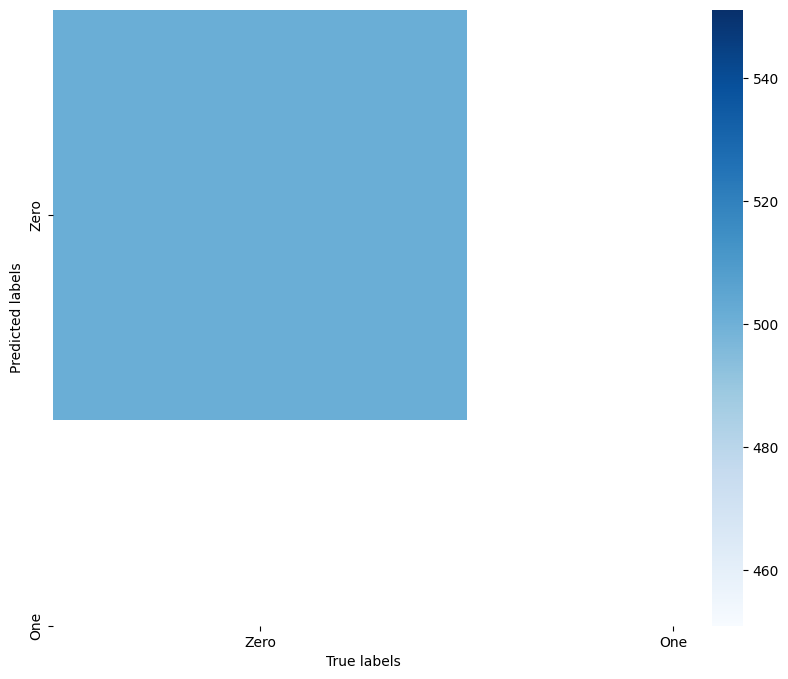

Predictions Shape: (501, 1)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


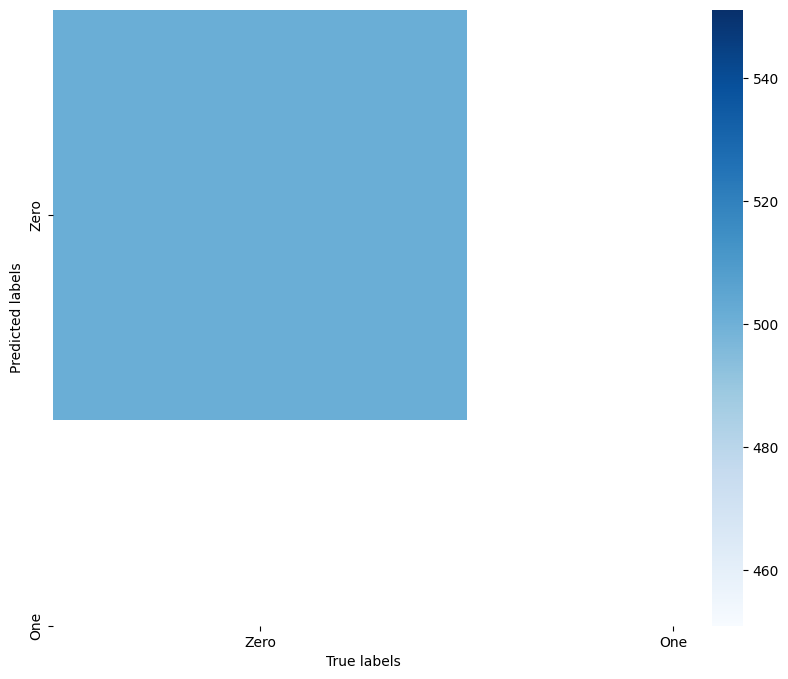

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Define a mapping of labels to their corresponding digit names
labels = {0:'Zero', 1:'One'}

num_models = len(models)

for i in range(0,num_models-1):
  # Predict labels for the entire test set
  predictions = models[i].predict(X_test, verbose=0)

  # Display the shape of the predictions
  print("Predictions Shape:", predictions.shape)

  # Compute the confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

#Crossvalidation

In [ ]:
def crossvalidate(model, folds):
  # Define the number of folds for cross-validation

  # Initialize lists to store training histories, scores, and best epochs
  histories = []
  scores = []
  best_epochs = []

  initial_weights = model.get_weights()

  # Create a KFold cross-validation object
  kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    model.set_weights(initial_weights)

    # Train the model on the training data for this fold

    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y[train_idx]), y=y[train_idx])

    class_weights = {
        0: weights[0],
        1: weights[1]
    }

    datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

    history = model.fit(
          datagen.flow(preprocess_input(X_train * 255), y_train, batch_size=32,subset='training'),
          y = y[train_idx],
          batch_size = 64,
          class_weight=class_weights,
          epochs = 20,
          validation_data=datagen.flow(preprocess_input(X_val * 255), y_val, batch_size=8, subset='validation'),
          callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True, start_from_epoch=10),
            tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
    ).history


    histories.append(history)
    best_epochs.append(len(history['loss']) - 30)

  return histories, best_epochs

  # Evaluate the model on the validation data for this fold
  #score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
  #scores.append(score[1])

  # Calculate the best epoch for early stopping
  # Store the training history for this fold
  #histories.append(history)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      #tfkl.RandomFlip("horizontal_and_vertical"),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      #tf.keras.layers.RandomBrightness(0.3, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomBrightness(0.2, value_range=(0,1)),
  ])
]


models = [
    build_efficient(X_train.shape[1:], neurons=[128, 64], dropout=0.5, batch_normalization=True, learning_rate=8e-5, weight_decay=5e-5, name="EfficientNet", augmentation=augmentations[0]),
    build_mobile(X_train.shape[1:], neurons=[64, 16], dropout=0.2, batch_normalization=True, learning_rate=8e-5, weight_decay=2e-5, name="MobileNetV2", augmentation=augmentations[0]),
    build_xception(X_train.shape[1:], neurons=[64, 16], dropout=0.2, batch_normalization=False, learning_rate=8e-5, weight_decay=2e-5, name="Xception", augmentation=augmentations[0])
    ]

histories = []
best_epochs = []

for i, model in enumerate(models):
  h, be = crossvalidate(model, 3)
  histories.append(h)
  best_epochs.append(be)

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dense_77 (Dense)            (None, 128)               196736    
                                                                 
 batch_normalization_56 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 activation_56 (Activation)  (None, 128)               0         
                                                                 
 dropout_70 (Dropout)        (None, 128)              

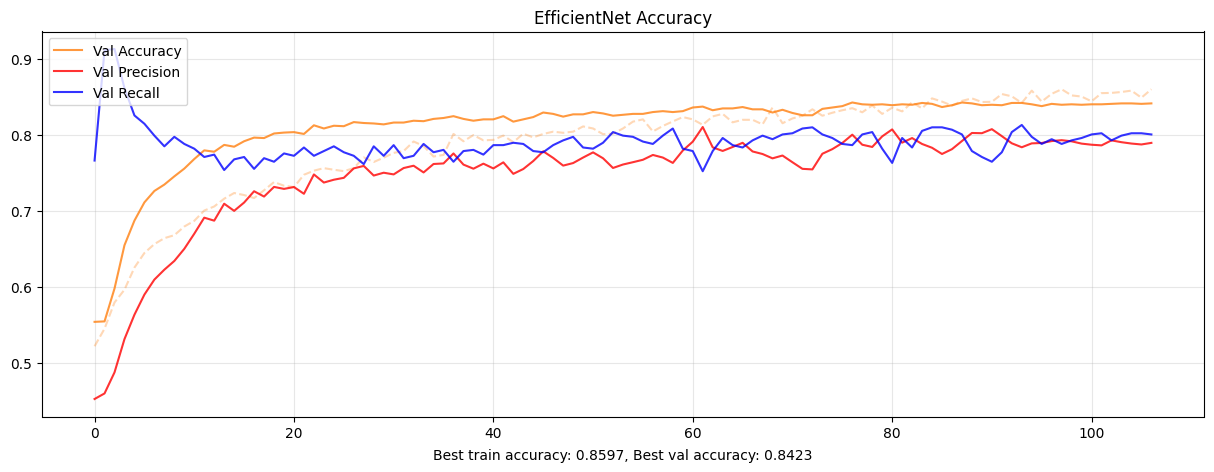

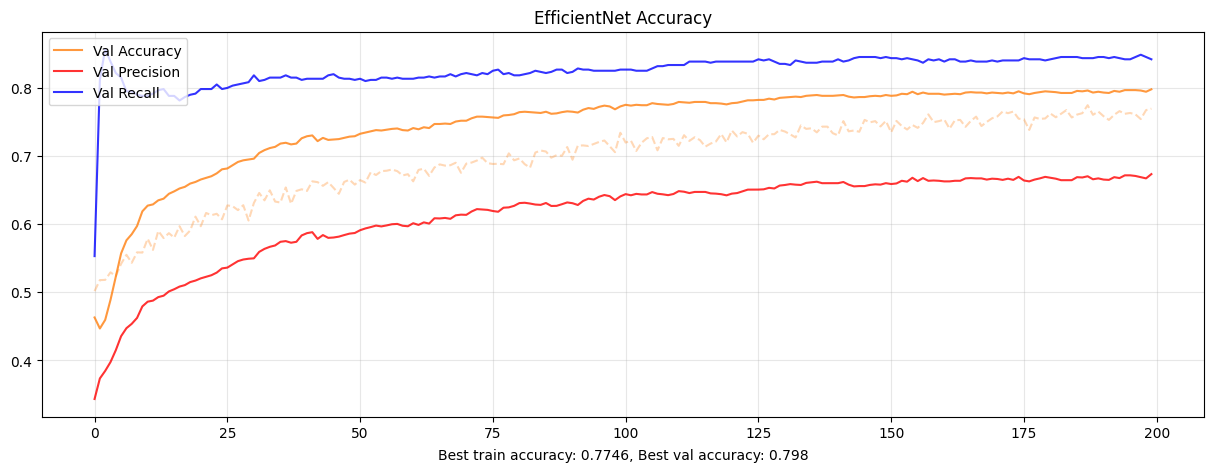

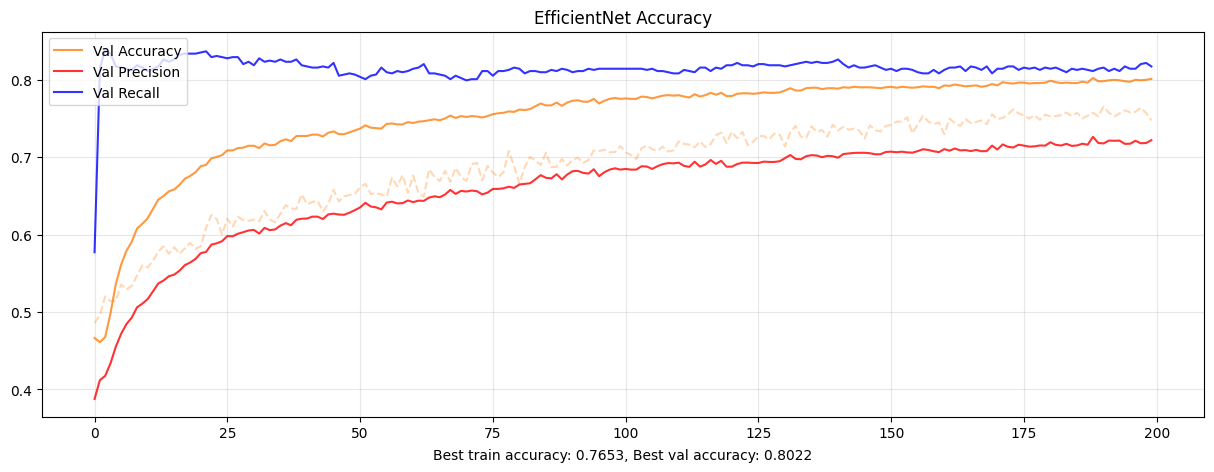

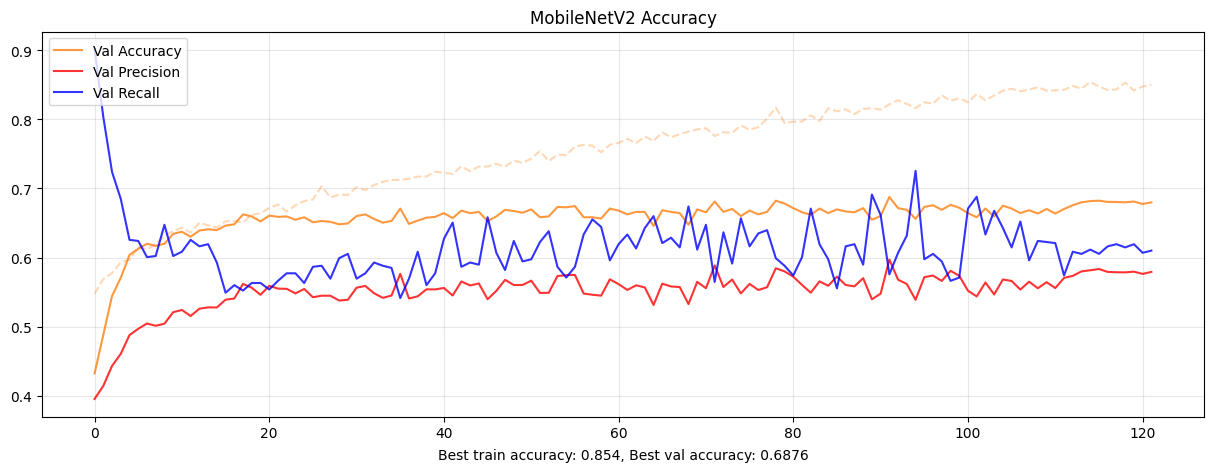

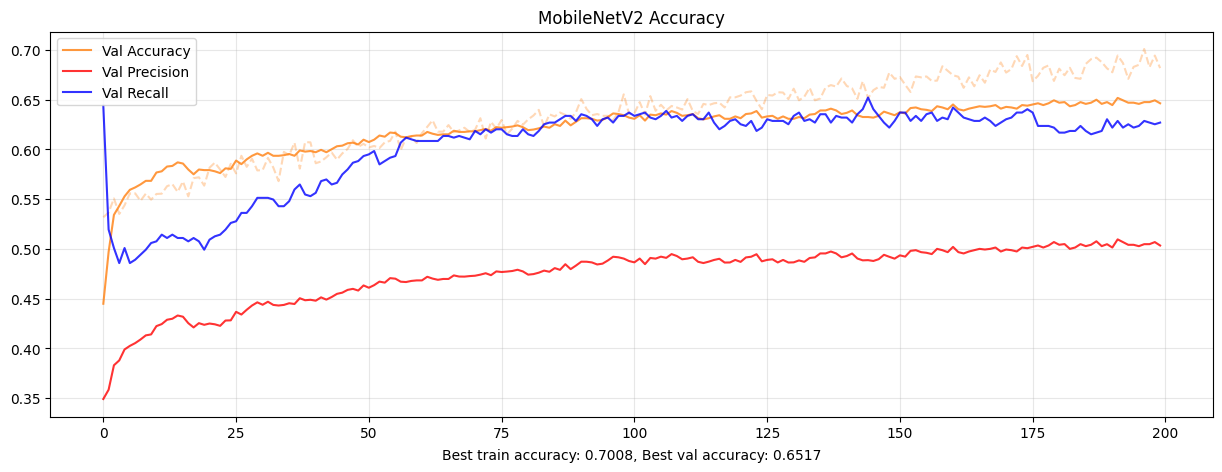

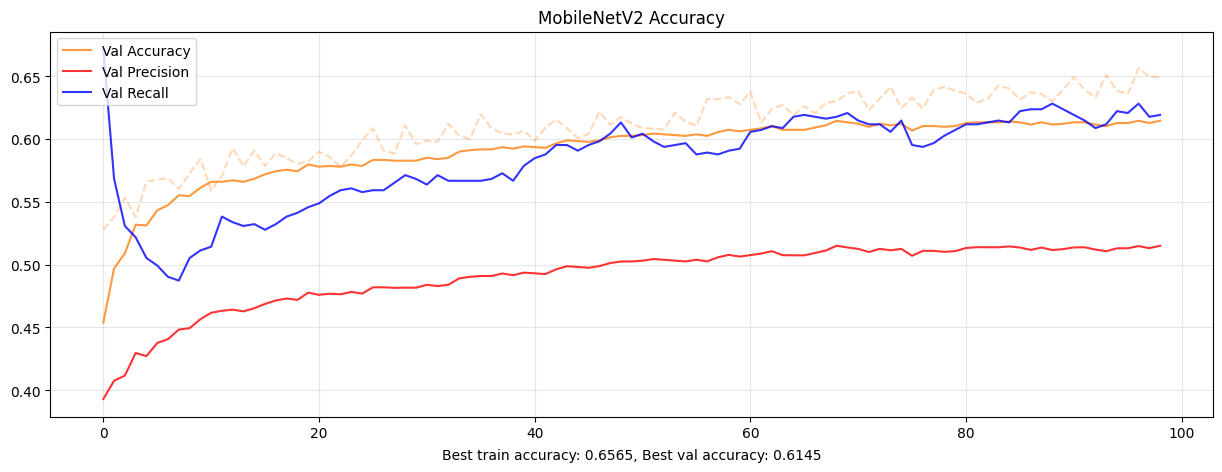

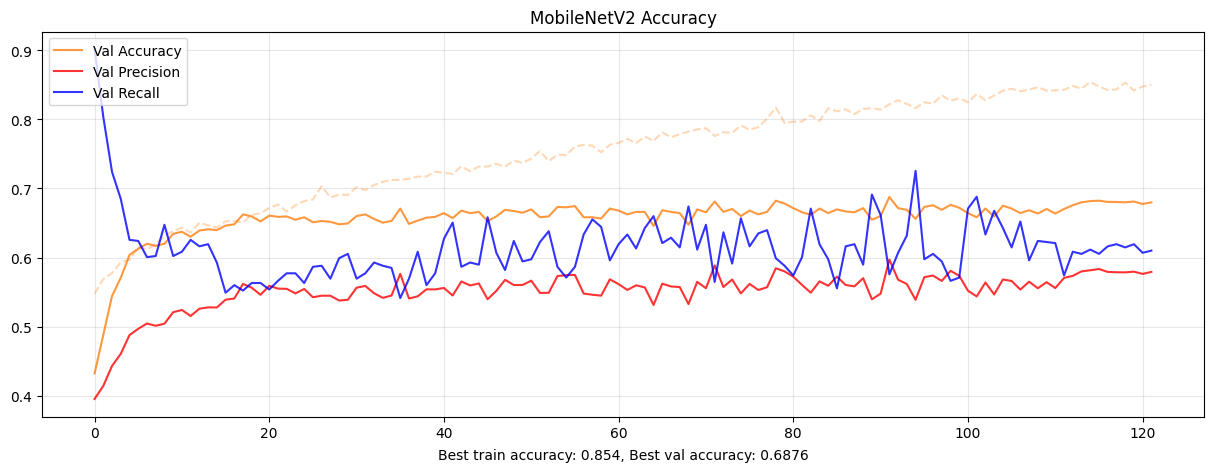

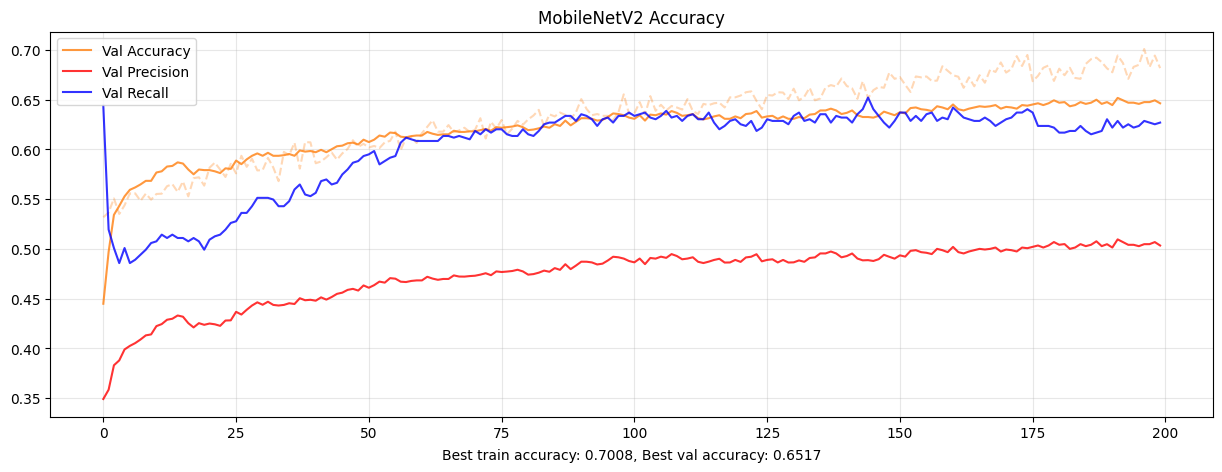

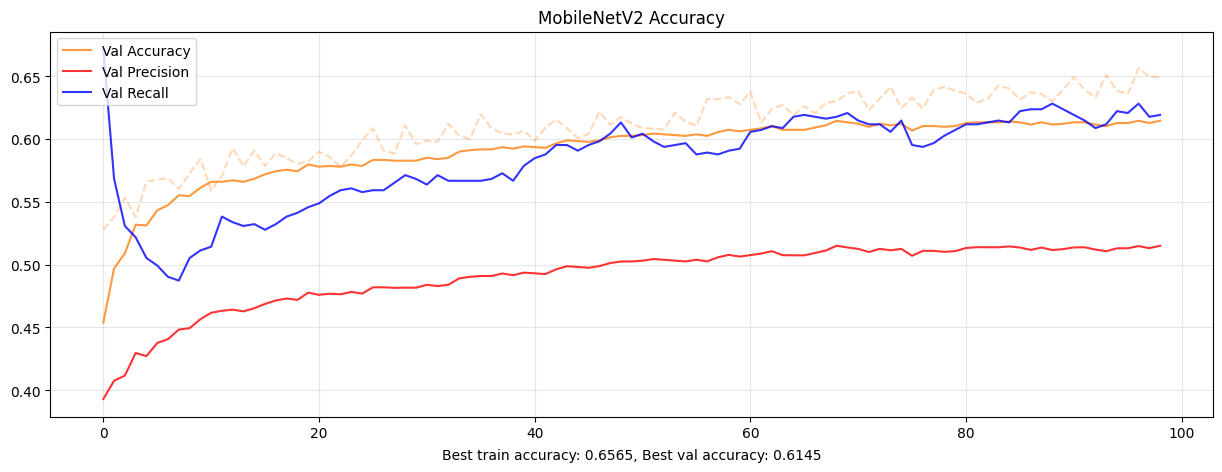

In [ ]:
for history in histories[0]:
  plot_history(history, "EfficientNet")
for history in histories[1]:
  plot_history(history, "MobileNetV2")
for history in histories[1]:
  plot_history(history, "MobileNetV2")

# Fine Tuning and performance analysis

In [ ]:
# Save transfer learning models
models[0].save("efficientnetv2b0_and_augmentation_NO_INVERSION")
#del models[0]

models[1].save("mobilenetv2_and_augmentation_NO_INVERSION")
#del models[1]

models[2].save("Xception_NO_INVERSION")
#del models[2]

In [ ]:
def fine_tune_efficient(layers, learning_rate):
  model = tf.keras.models.load_model('efficientnetv2b0_and_augmentation_NO_INVERSION')


  model.get_layer('efficientnetv2-b3').trainable = True

  # Freeze first N layers, e.g., until the 133rd one
  for i, layer in enumerate(model.get_layer('efficientnetv2-b3').layers[:layers]):
    layer.trainable=False

  for layer in model.get_layer('efficientnetv2-b3').layers[layers:]:
    print(layer)

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model

def fine_tune_mobile(layers, learning_rate):
  model = tf.keras.models.load_model('mobilenetv2_and_augmentation_NO_INVERSION')


  model.get_layer('mobilenetv2_1.00_96').trainable = True

  # Freeze first N layers, e.g., until the 133rd one
  for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:layers]):
    layer.trainable=False

  for layer in model.get_layer('mobilenetv2_1.00_96').layers[layers:]:
    print(layer)

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model


def fine_tune_xception(layers, learning_rate):
  model = tf.keras.models.load_model('efficientnetv2b0_and_augmentation_NO_INVERSION')


  model.get_layer('xception').trainable = True

  # Freeze first N layers, e.g., until the 133rd one
  for i, layer in enumerate(model.get_layer('xception').layers[:layers]):
    layer.trainable=False

  for layer in model.get_layer('xception').layers[layers:]:
    print(layer)

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model


In [ ]:
histories = []

models = [
    fine_tune_efficient(280, 3e-6),
    fine_tune_mobile(280, 3e-6),
    fine_tune_xception(280, 3e-6)
    #fine_tune_efficient(300, 3e-6),
    #fine_tune_efficient(320, 3e-6)
]

patience = 20

batch_size = 16

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = {
    0: weights[0],
    1: weights[1]
}

steps_per_epoch = len(X_train) // batch_size

for i, model in enumerate(models):

  if i == 0:
    x_train = preprocess_efficient(X_train * 255)
    x_val = preprocess_efficient(X_val * 255)
  elif i == 1:
    x_train = preprocess_mobile(X_train * 255)
    x_val = preprocess_mobile(X_val * 255)
  elif i == 2:
    x_train = preprocess_xception(X_train * 255)
    x_val = preprocess_xception(X_val * 255)
  else:
    x_train = preprocess_mobile(X_train * 255)
    x_val = preprocess_mobile(X_val * 255)

  histories.append(
      model.fit(
        datagen.flow(x_train, y_train, batch_size=32,subset='training'),
        class_weight=class_weights,
        batch_size = batch_size,
        epochs = 400,
        validation_data = datagen.flow(x_val, y_val, batch_size=8, subset='validation'),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True, start_from_epoch=5),
          #tfk.callbacks.ModelCheckpoint('modelB' + str(i) + '_weights_epoch_{epoch:02d}.h5', save_weights_only=True, save_freq=5 * steps_per_epoch),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-7, mode='max')
        ]
  ).history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


16/16 [==============================] - 3s 29ms/step
0.8313798344874177


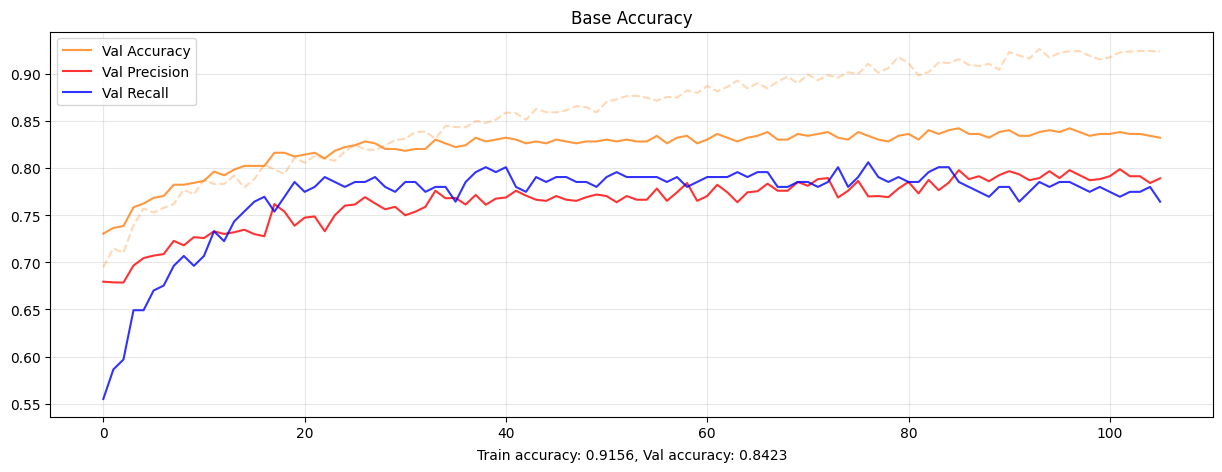

In [ ]:
for i, history in enumerate(histories):
  predictions = models[i].predict(preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  plot_history(history, models[i].name, patience=patience)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Define a mapping of labels to their corresponding digit names
labels = {0:'Zero', 1:'One'}

num_models = len(models)

for i in range(0,num_models-1):
  # Predict labels for the entire test set
  predictions = models[i].predict(X_test, verbose=0)

  # Display the shape of the predictions
  print("Predictions Shape:", predictions.shape)

  # Compute the confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

In [ ]:
models[0].save('Efficientnet_finetuned_NO_INVERSION')
models[1].save('mobilenetv2_finetuned_NO_INVERSION')
models[2].save('Xception_NO_INVERSION_finetuned')